In [ ]:
%load_ext autoreload
%autoreload 2


import scanpy as sc
import seaborn as sns
import pandas as pd
from scipy.stats import median_abs_deviation
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import scrublet as scr
from tqdm.notebook import tqdm
from diptest import diptest
from scipy.sparse import csr_matrix
import anndata as ad
import math
import scvi


from utils import preprocessing

# Hyperparamyters
LIBRARIES = ["SI-TT-H1", "SI-TT-H2", "SI-TT-H3"]
BCL = "240805_SL-EXD_0328_B22FKKYLT4"
PATIENCE_ID = "diseased_1"

CELL_TYPE_ANNOTATION_LEVEL_SCANVI = "Class_name"
BATCH_SIZE=512
SCVI_EPOCHS = 100
SCANVI_EPOCHS = int(SCVI_EPOCHS/5)
SCANVI_LATENT_KEY = "X_scANVI"

# Load adata

In [2]:
adata_list = []

for lib in tqdm(LIBRARIES):
    ADATA_PATH = f'/home/gdallagl/myworkdir/XDP/data/XDP/disease/{BCL}/{lib}/adata/reprocessed_filtered_adata.h5ad'
    adata = sc.read_h5ad(ADATA_PATH)

    # Create minimal adata
    adata.obs = adata.obs[['x', 'y', 'pct_intronic', 'is_cell', 'dbscan_clusters', 'dbscan_score', 'has_spatial', 
                           
                           'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 
                           'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 
                           'Subclass_name', 'Subclass_bootstrapping_probability', 'Subclass_aggregate_probability',
                           'Group_name', 'Group_bootstrapping_probability', 'Group_aggregate_probability',
                           'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability',

                           'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 
                           
                           'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 

                           'my_hierarchy', 'my_hierarchy_all']]
    
    adata.var = adata.var[['feature_types', 'genome', 'gene_symbol']]

    adata.obsm = {k: adata.obsm[k].copy() for k in ('spatial',) if k in adata.obsm}
    adata.layers = {k: adata.layers[k].copy() for k in ('counts',) if k in adata.layers}

    # add library index
    adata.obs["library"] = BCL + "---" + lib
    adata.obs["library_name"] = lib
    adata.obs_names = adata.obs["library"] + "---" + adata.obs_names.astype(str)

    # restart from raw counts
    adata.X = adata.layers["counts"].copy()

    # add ot list
    adata_list.append(adata)

print(adata_list)

  0%|          | 0/3 [00:00<?, ?it/s]

[AnnData object with n_obs × n_vars = 27727 × 33866
    obs: 'x', 'y', 'pct_intronic', 'is_cell', 'dbscan_clusters', 'dbscan_score', 'has_spatial', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Subclass_aggregate_probability', 'Group_name', 'Group_bootstrapping_probability', 'Group_aggregate_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'my_hierarchy', 'my_hierarchy_all', 'library', 'library_name'
    var: 'feature_types', 'genome', 'gene_symbol'
    uns: 'Subclass_name_colors', 'hvg', 'is_mixed_cluster_doublet_colors', 'is_oligo_doublet_colors', 'is_sc

# Concat

In [3]:
adata = sc.concat(adata_list, 
                  #label='library',
                  # Not aligned to the concatenation axis (i.e., things in .uns, .var, .varm, .obsm, etc.) are selected/combined
                  index_unique='-' ,
                  keys=LIBRARIES,
                  join='inner')  # keeps COMMON genes


del adata_list

print(adata)
display(adata.obs)
assert adata.obs_names.is_unique, "ERROR: adata.obs_names are not unique!"


AnnData object with n_obs × n_vars = 84669 × 32780
    obs: 'x', 'y', 'pct_intronic', 'is_cell', 'dbscan_clusters', 'dbscan_score', 'has_spatial', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Subclass_aggregate_probability', 'Group_name', 'Group_bootstrapping_probability', 'Group_aggregate_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'my_hierarchy', 'my_hierarchy_all', 'library', 'library_name'
    obsm: 'spatial'
    layers: 'counts'


x  \
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...  21225.159553   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...  16429.015488   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...  43242.438818   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...  14118.369028   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...  56670.296375   
...                                                          ...   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...   7312.232149   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...  11313.567114   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...  31393.199291   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...  46188.098628   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...  43884.375265   

                                                               y  \
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...   4193.340108   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...   3852.143369   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...  -1822.457007   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...  -4852.270550   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...   8783.447219   
...                                                          ...   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...   5689.570899   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...   8499.633020   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...   -120.827487   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...  -7745.600240   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...  14036.552216   

                                                    pct_intronic  is_cell  \
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...      0.596834     True   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...      0.716821     True   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...      0.609493     True   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...      0.588186     True   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...      0.682462     True   
...                                                          ...      ...   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...      0.671489     True   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...      0.751973     True   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...      0.610678     True   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...      0.691346     True   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...      0.646723     True   

                                                    dbscan_clusters  \
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...                1   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...                1   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...                0   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...                1   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...                1   
...                                                             ...   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...                1   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...                1   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...                1   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...                1   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...                1   

                                                    dbscan_score  has_spatial  \
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...      0.942997         True   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...      0.936590         True   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...      0.366933        False   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...      0.859807         True   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H1---AAAC...      0.934197         True   
...                                                          ...          ...   
240805_SL-EXD_0328_B22FKKYLT4---SI-TT-H3---GTTG...      0.790263         True   
240

# Remove cell type

scANVI is trained on cell types, need to have enogh of them. 

Remove cells that beloincs ot cell types wiht <N values.

Use broad cell type category to not losse too mnay cells.

In [4]:
# min_cells = 5
# # Class_name --> very broad
# cell_type_counts = adata.obs[CELL_TYPE_ANNOTATION_LEVEL_SCANVI].value_counts()
# valid_cell_types = cell_type_counts[cell_type_counts >= min_cells].index

# print(f"Before filtering: {adata.n_obs} cells")
# adata = adata[adata.obs['Class_name'].isin(valid_cell_types)].copy()
# print(f"After filtering: {adata.n_obs} cells")
# print(f"Removed: {cell_type_counts[cell_type_counts < min_cells].sum()} cells")


# Preprocess

Normalizing...
Findingn HVGs...


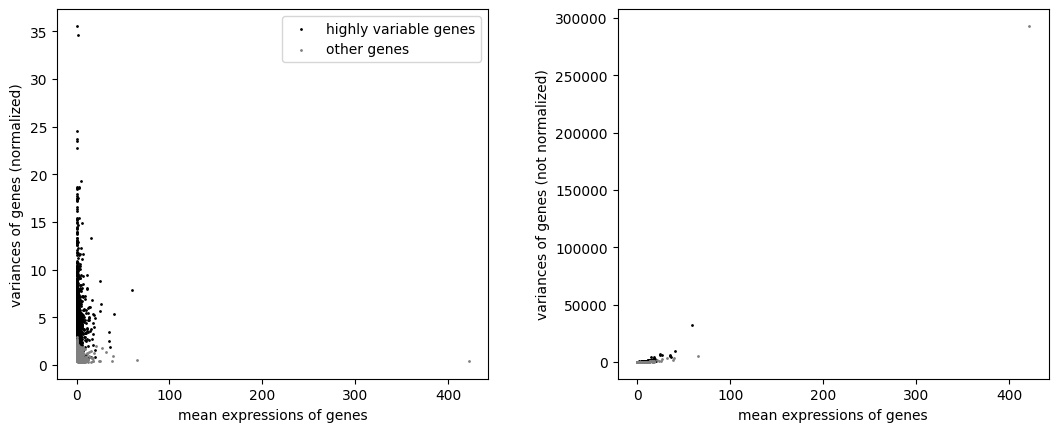

Scaling...


/home/gdallagl/.pyenv/versions/3.11.8/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Calculating PCA...


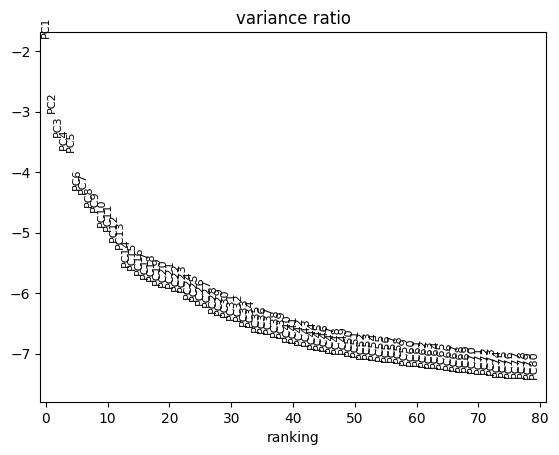

Calculating neightbors...
Calculating Umap...
Clutering...


In [5]:
preprocessing.preprocess(adata, n_pcs_elbow=30, n_hvg=3000, hvg_layer='counts', hvg_batch_key="library")

# Plot

/tmp/ipykernel_194268/2802814584.py:16: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  for i, lib in enumerate(adata.obs.library_name.unique().to_list(), start=1):


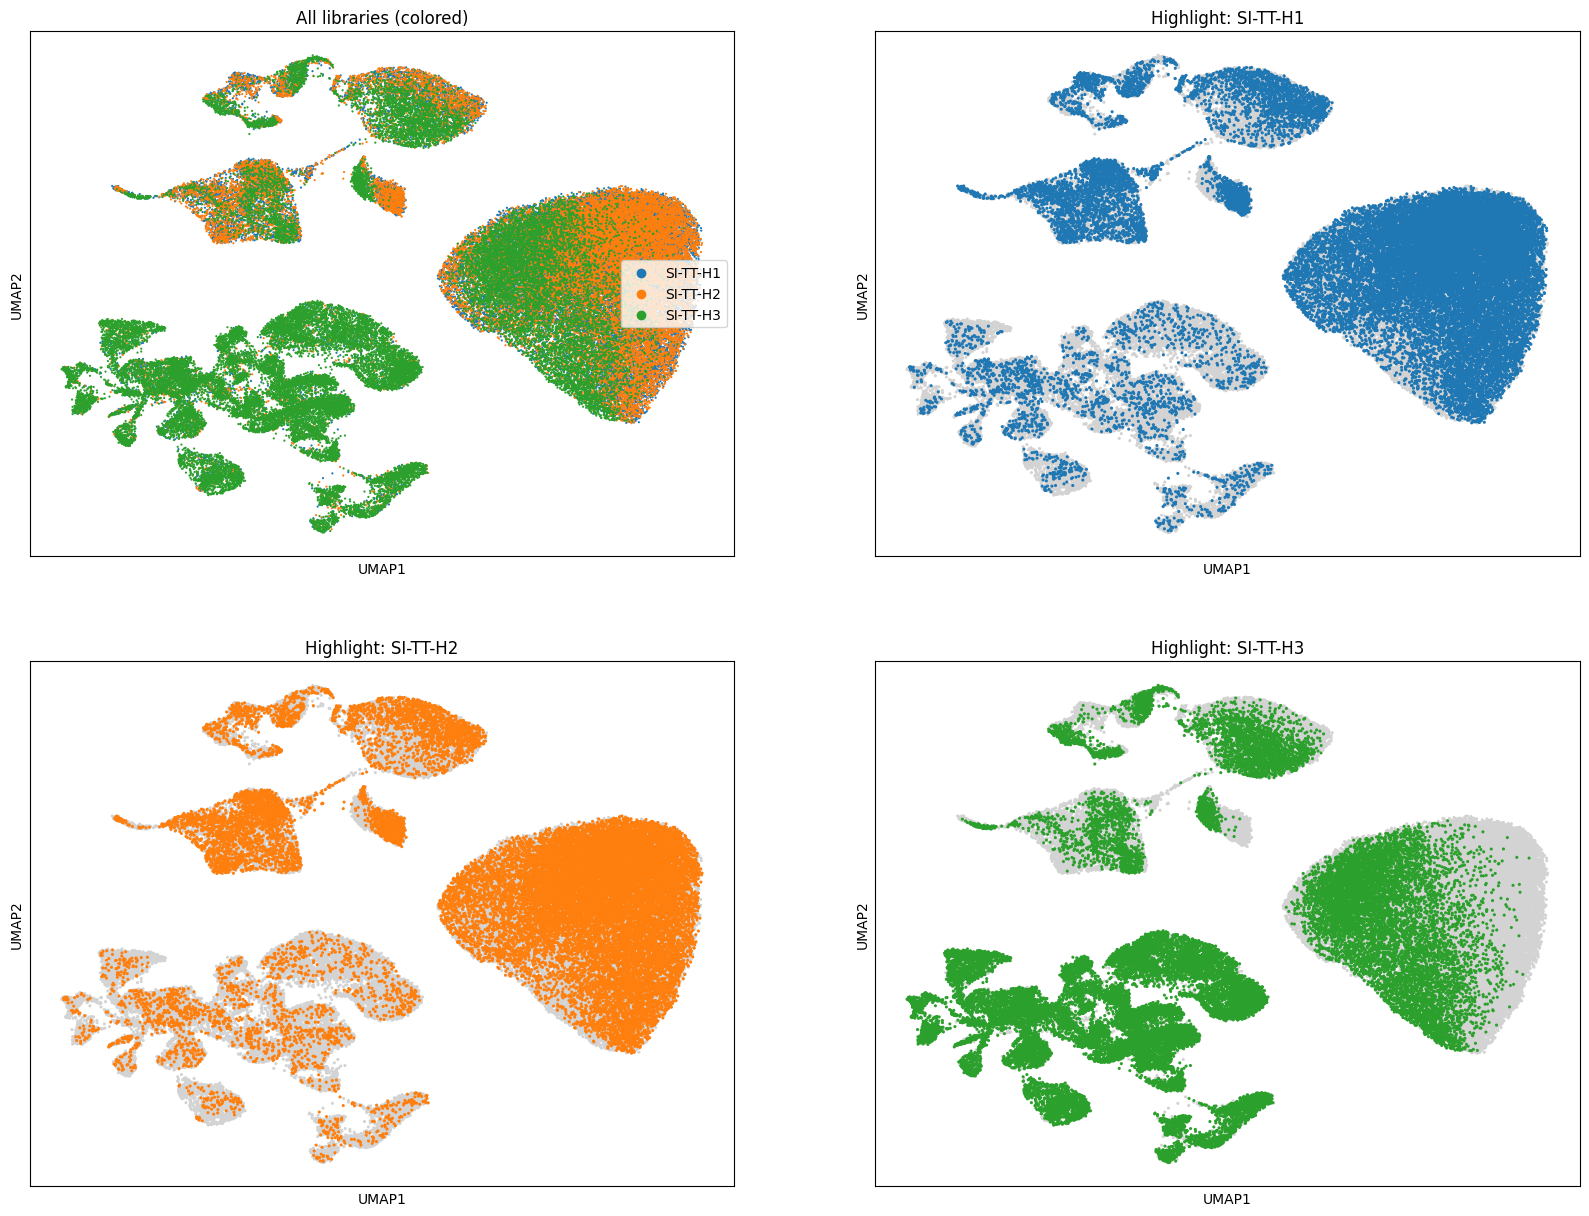

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

# 1) Combined plot: color by library
sc.pl.umap(
    adata,
    color="library_name",
    ax=axes[0],
    legend_loc="right",
    title="All libraries (colored)",
    show=False,
    size=10
)

# 2..4) Highlight each selected library (colored) and gray-out others
for i, lib in enumerate(adata.obs.library_name.unique().to_list(), start=1):

    sc.pl.umap(
        adata,
        color="library_name",
        ax=axes[i],
        title=f"Highlight: {lib}",
        legend_loc=None,
        show=False,
        size=20,
        groups=[lib],
    )

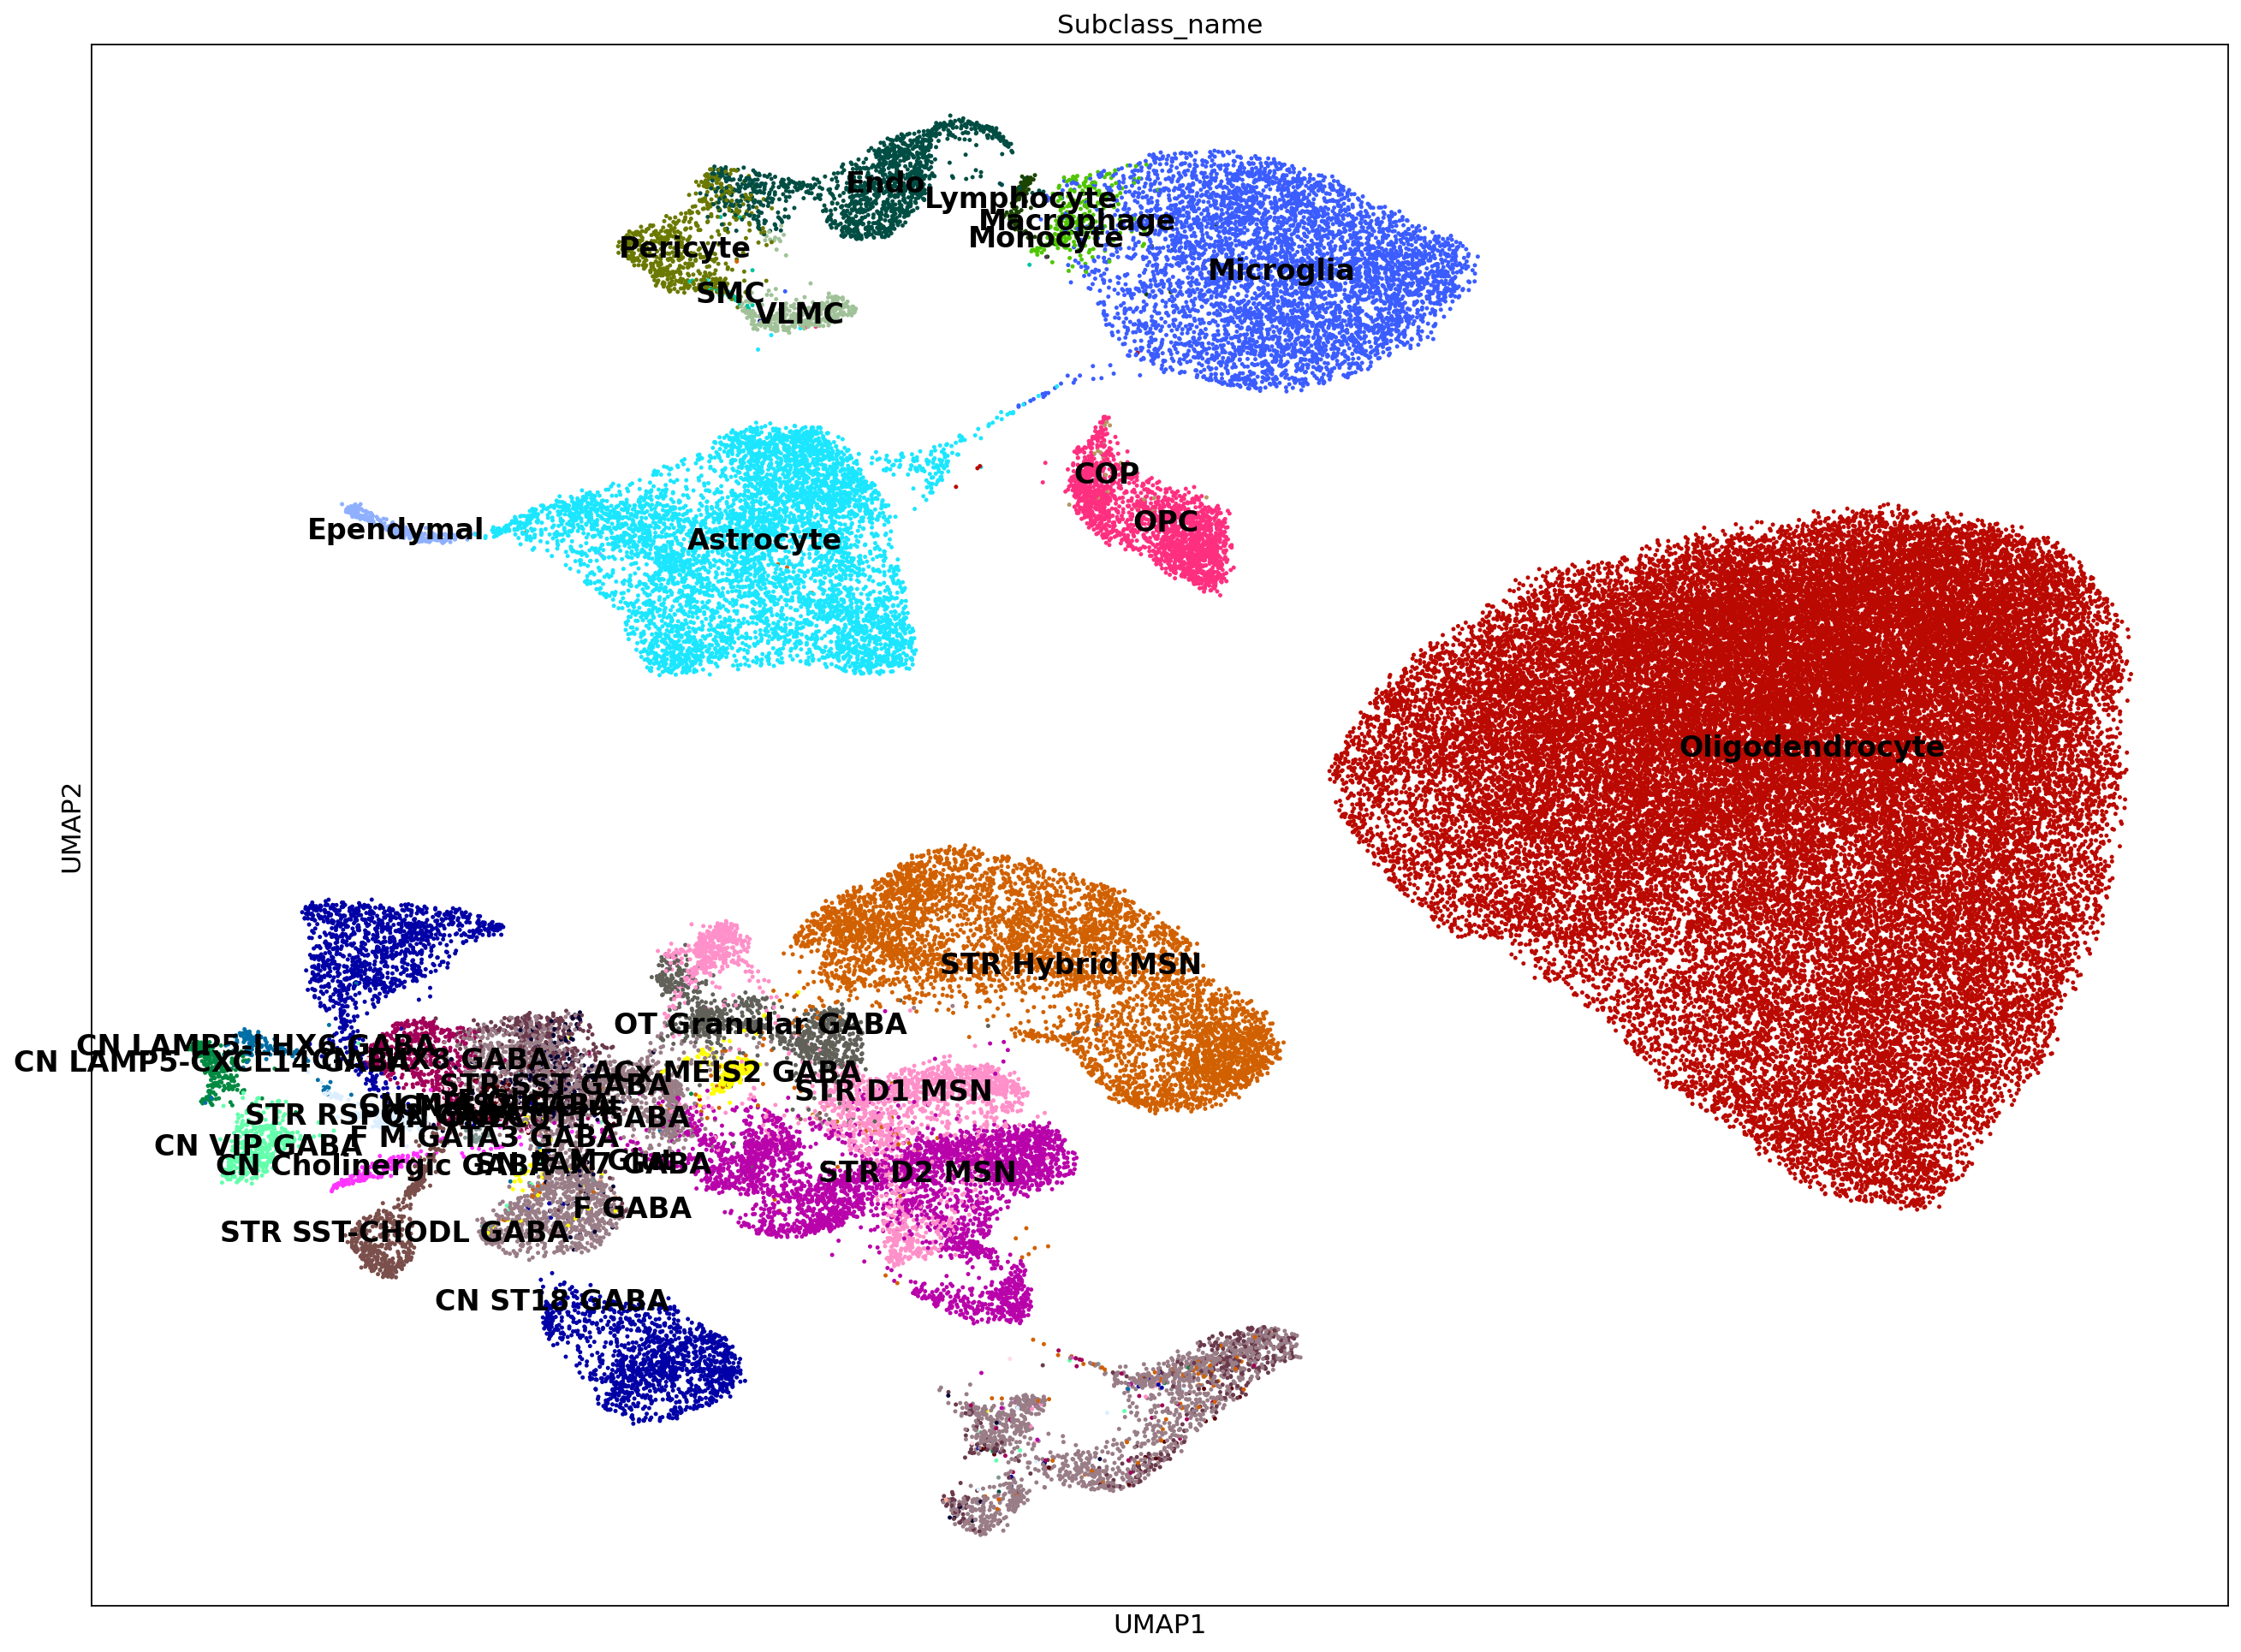

In [7]:
sc.settings.set_figure_params(figsize=(20, 15))  # increase size globally
sc.pl.umap(
    adata,
    color=["Subclass_name"],
    legend_fontsize=15,
    size=20,
    ncols=1,
    legend_loc="on data"
)

# scANVI Intergration

## Check scanvi requirements

In [8]:
# same genes name

# cuunt matrix
x = adata.layers["counts"][1, :1000].toarray().flatten()
x[x != 0]

array([ 1,  1,  3,  1,  6,  3,  4,  2,  1,  1,  4,  1,  1,  2,  2,  1,  1,
        1,  1,  3,  1,  1,  1,  1,  2,  1,  1,  3,  5,  1,  1,  2,  1,  4,
        1,  1,  1,  1,  1,  1,  1,  3,  1,  1,  2,  1,  1,  1,  1,  2,  7,
        1,  3,  6,  2,  2,  3, 45,  2,  1,  6,  3,  1])

In [9]:
# Make adata with HVG only
adata_hvg = adata[:, adata.var.highly_variable].copy()

## Train scVI

In [10]:
# Initialise adata 
scvi.model.SCVI.setup_anndata(
    adata_hvg,
    layer='counts', # ATTTENTION NEEDS RAW COUNTS
    batch_key='library',
    # labels_key=None,          # Optional: cell type labels (not used in scVI)
    # categorical_covariate_keys=None,  # Additional covariates
    # continuous_covariate_keys=None    # Continuous covariates
)

# create scVI object (unsupervised)
scvi_model = scvi.model.SCVI(
    adata_hvg,
    n_latent=30,
    n_layers=2,
)

# train
scvi_model.train(
    max_epochs=SCVI_EPOCHS, 
    early_stopping=True,
    batch_size=BATCH_SIZE,
    datasplitter_kwargs={'num_workers': 16}
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


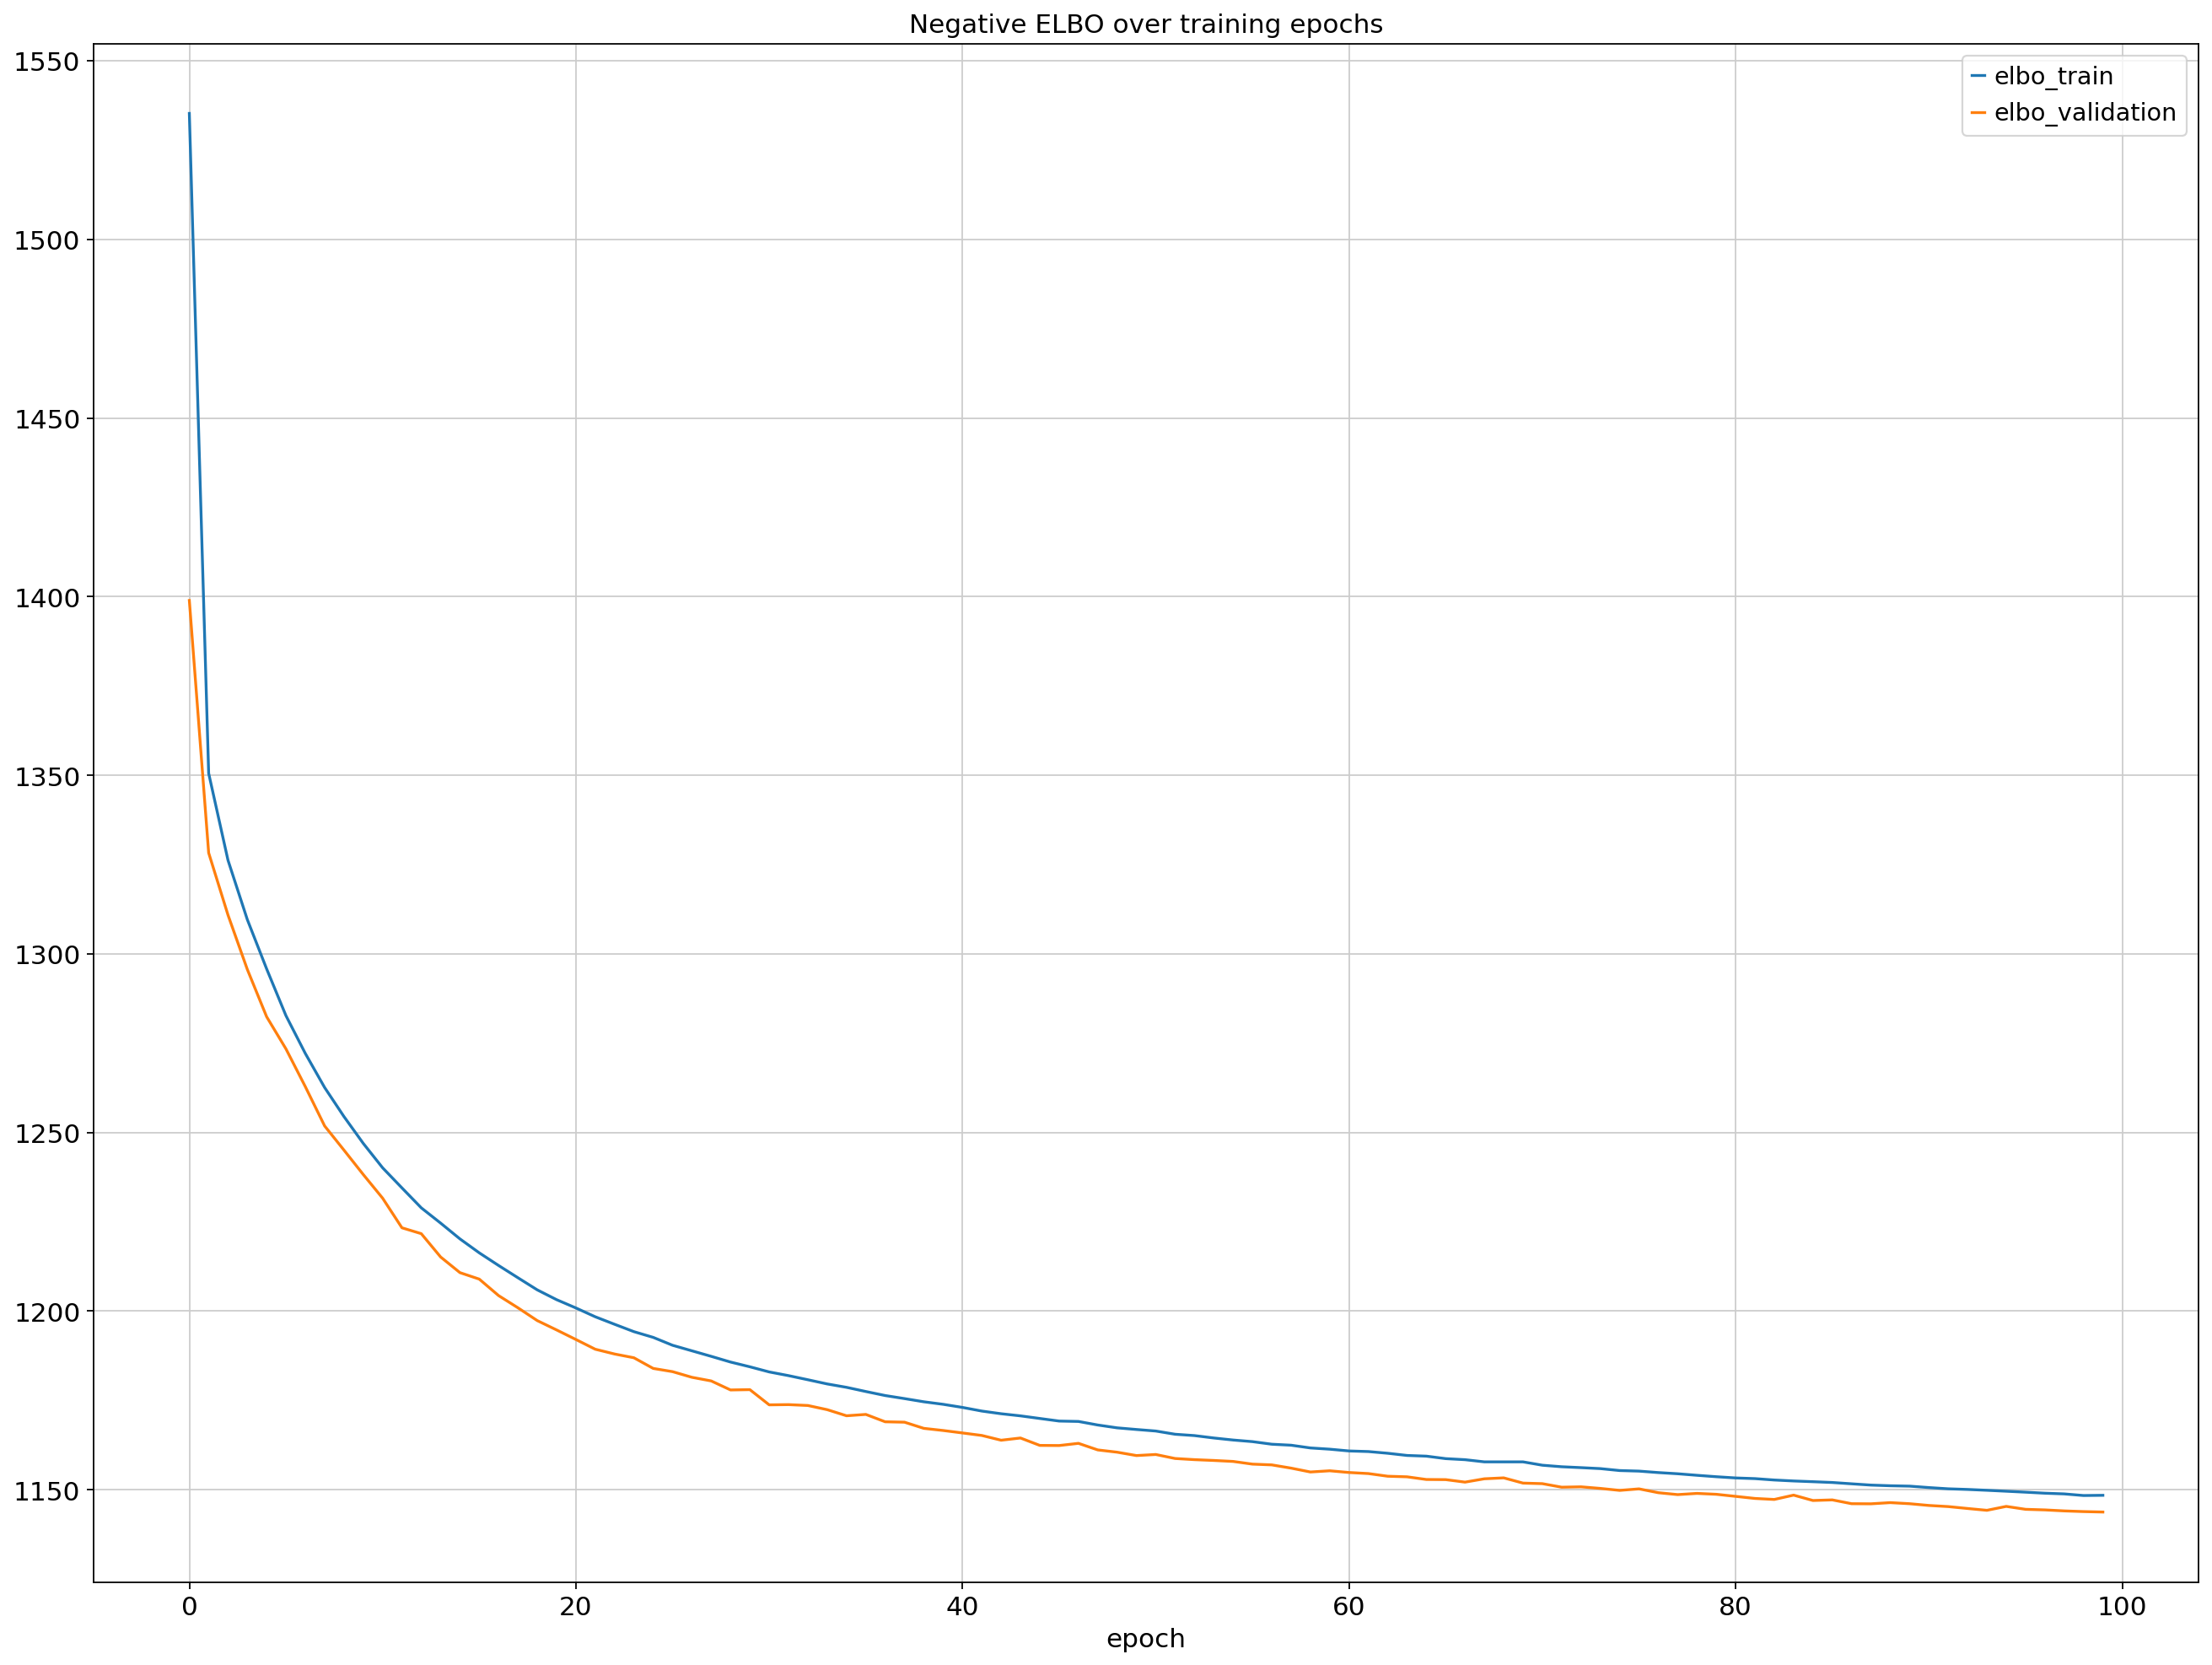

In [11]:
fig, ax = plt.subplots(1, 1)
scvi_model.history["elbo_train"].plot(ax=ax, label="train")
scvi_model.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs")
ax.legend()

## Train on top scANVI

In [17]:
print(adata_hvg.obs[CELL_TYPE_ANNOTATION_LEVEL_SCANVI].value_counts().tail(10))

# Count cell types and get min class size
n_cell_types = adata_hvg.obs[CELL_TYPE_ANNOTATION_LEVEL_SCANVI].nunique()
min_class_size = adata_hvg.obs[CELL_TYPE_ANNOTATION_LEVEL_SCANVI].value_counts().min()
# Choose n_samples_per_label (use 80% of smallest class to be safe)
n_samples_per_label = 20#int(min_class_size * 0.8)
print(f"\nUsing n_samples_per_label = {n_samples_per_label}")
print(f"Effective batch size = {n_samples_per_label * n_cell_types}")

Subclass_name
CN MEIS2 GABA      139
Lymphocyte         125
F Glut             102
SMC                 42
F M GATA3 GABA      30
COP                 23
SN PAX7 GABA        10
Monocyte             3
CN GABA-Glut         1
CN ONECUT1 GABA      1
Name: count, dtype: int64

Using n_samples_per_label = 20
Effective batch size = 700


In [18]:
# Intialize scanvi model from scvi
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata_hvg, # ATTENTION: scANVI should be initialized from a scVI model pre-trained on the same exact data.
    labels_key=CELL_TYPE_ANNOTATION_LEVEL_SCANVI,
    unlabeled_category='Unknown'
)

# train 
scanvi_model.train(
    max_epochs=SCANVI_EPOCHS, 
    batch_size=BATCH_SIZE,
    n_samples_per_label=n_samples_per_label,  # Sample exactly 100 cells per cell type PER EPOCH
    datasplitter_kwargs={'num_workers': 16},
    plan_kwargs={
        "lr": 5e-4, # low
        'n_epochs_kl_warmup': 10,  # Warmup over 10 epochs
        },
    early_stopping=True) # lees epochs as starts form pretrained


INFO     Training for 20 epochs.                                                                                   


/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:187: UserWarning: Category 3 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/scvi/data/fields/_scanvi.py:56: UserWarning: Category 3 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/20 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


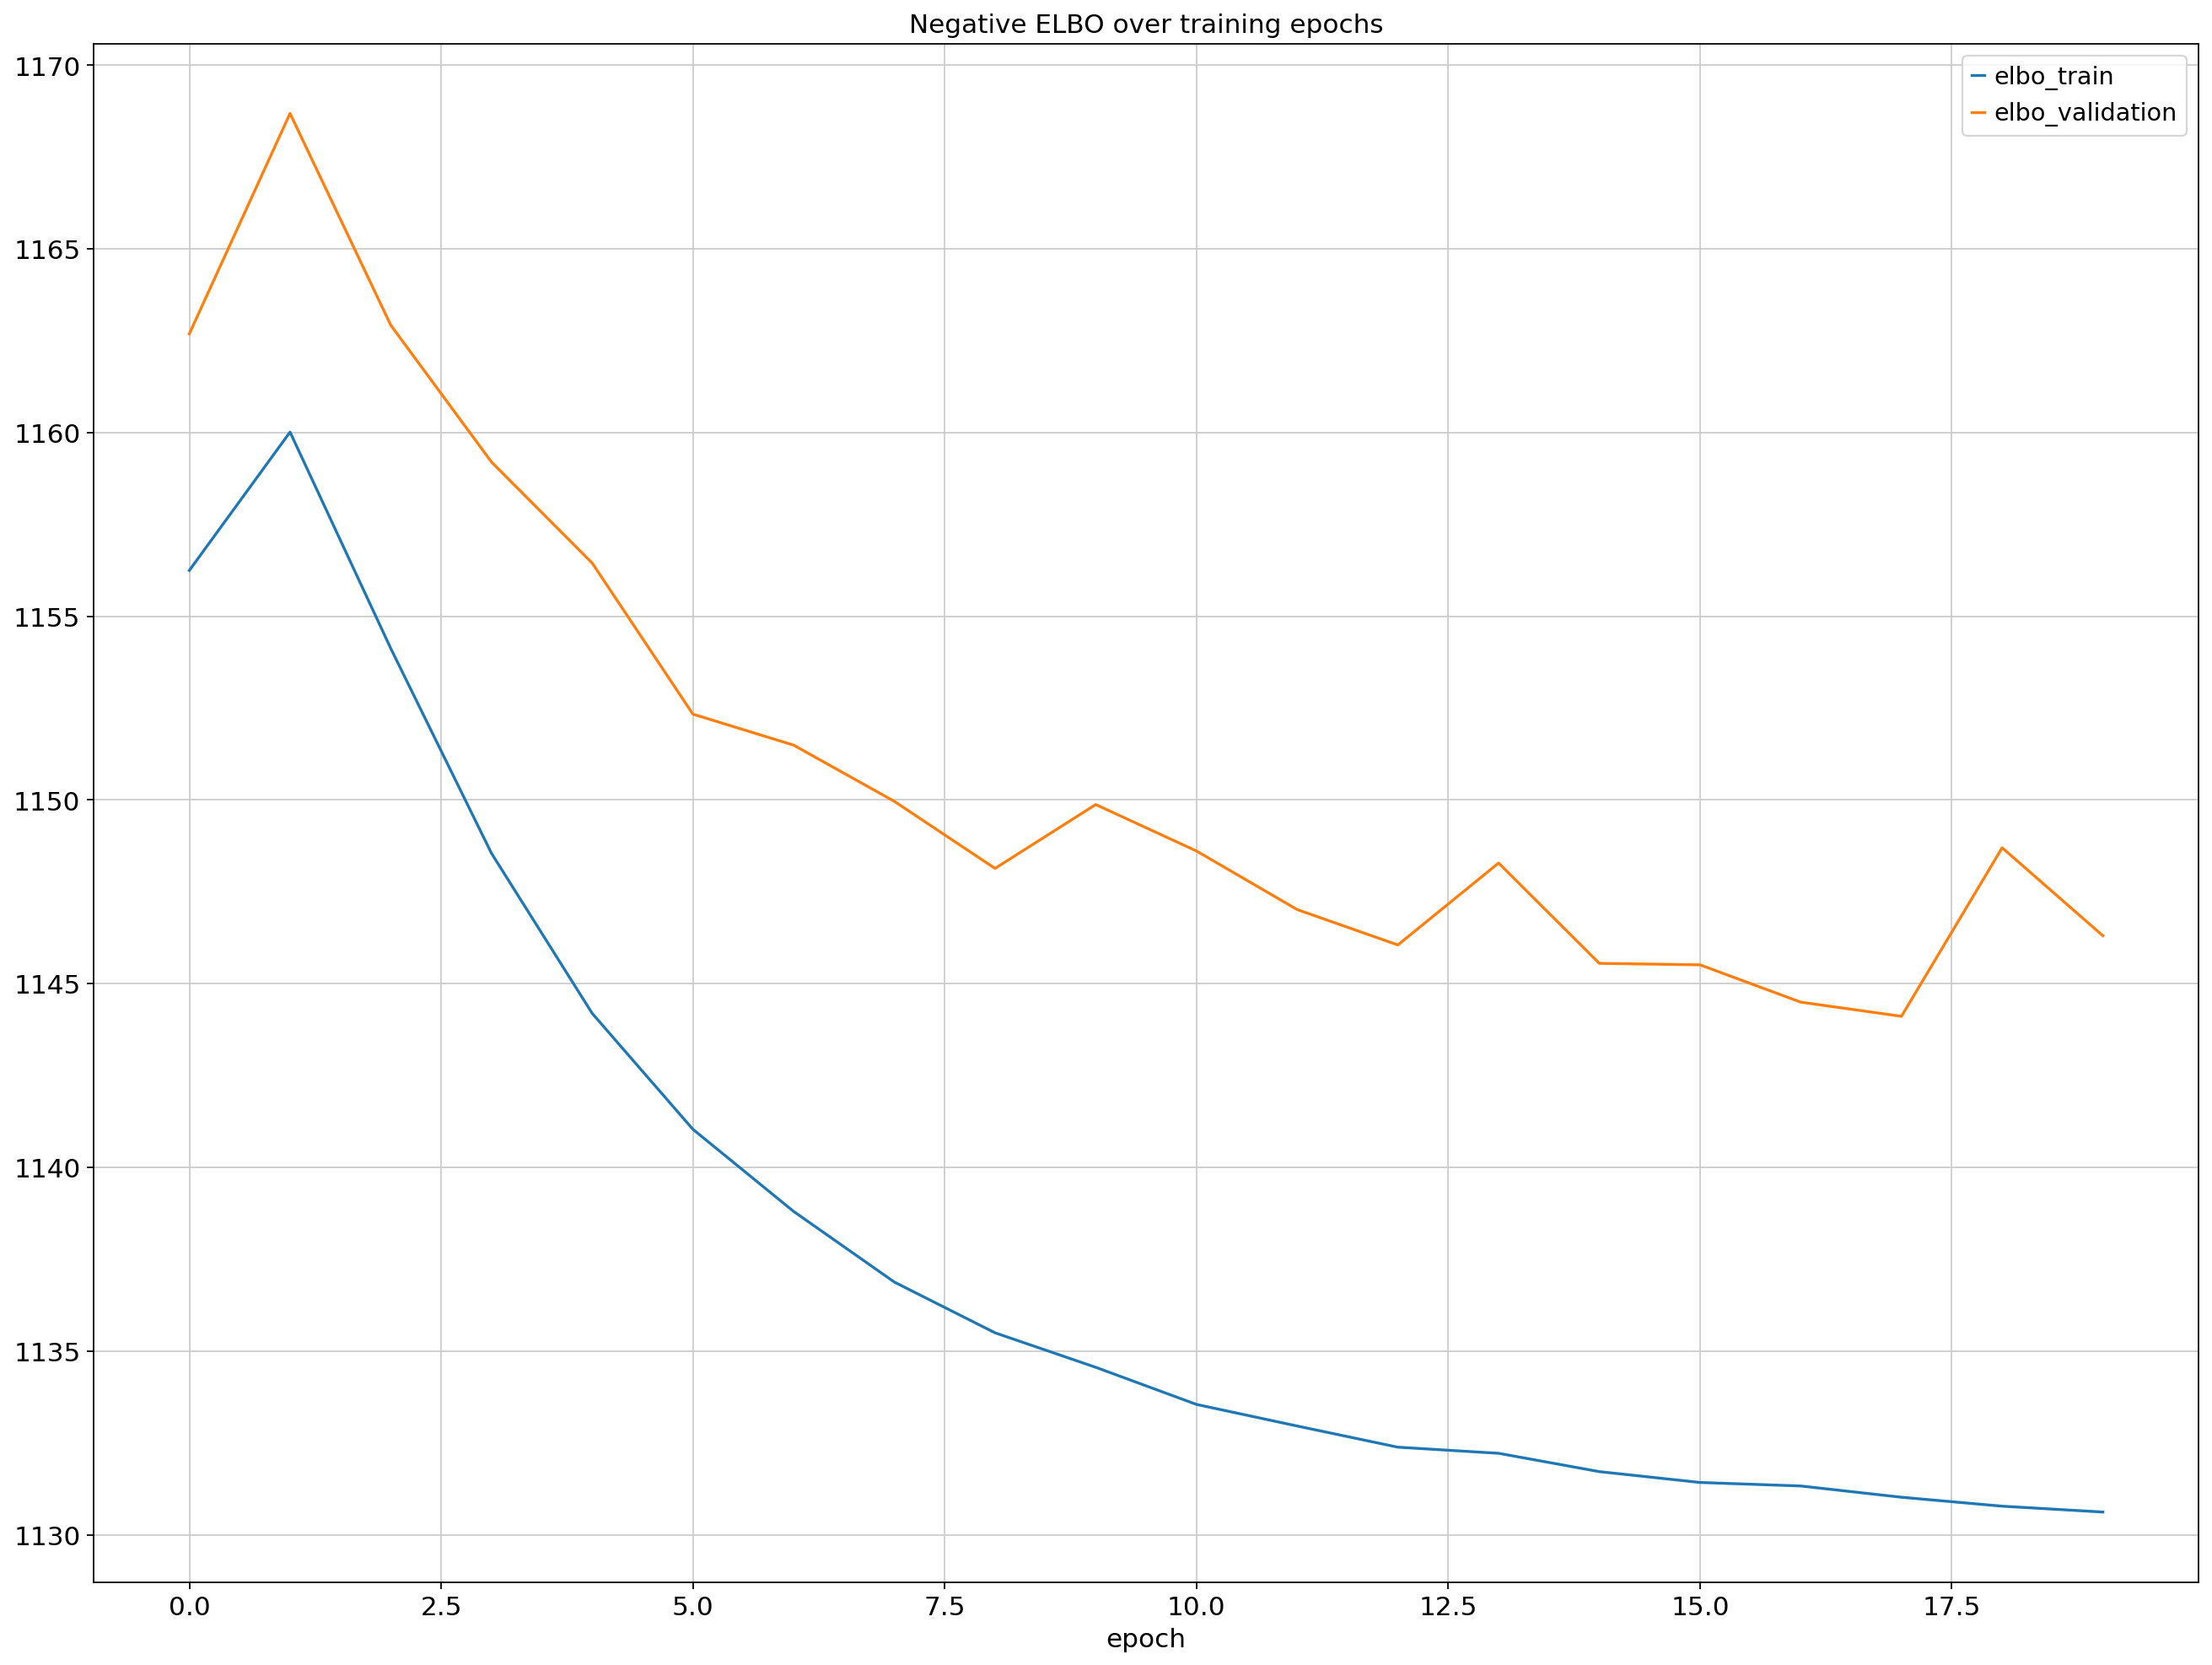

In [19]:
fig, ax = plt.subplots(1, 1)
scanvi_model.history["elbo_train"].plot(ax=ax, label="train")
scanvi_model.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs")
ax.legend()

## Process Latent space

In [20]:
# Save latent
    #ATTENTION: put in old adata --> cells in same order??
assert (adata.obs_names == adata_hvg.obs_names).all(), "Cell order mismatch!"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation() # latnet embs (sort ot PCA)
#adata.layers['scANVI_normalized'] = scanvi_model.get_normalized_expression() # corrected NORMALISED counts

# compute UMAP
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY, key_added='scANVI_neighbors')
sc.tl.umap(adata, neighbors_key='scANVI_neighbors', key_added='scANVI_umap')
sc.tl.leiden(adata, resolution=1.0, key_added="leiden_scANVI", flavor="igraph", n_iterations=2, neighbors_key='scANVI_neighbors')


## Plot

/tmp/ipykernel_194268/738449846.py:17: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  for i, lib in enumerate(adata.obs.library_name.unique().to_list(), start=1):


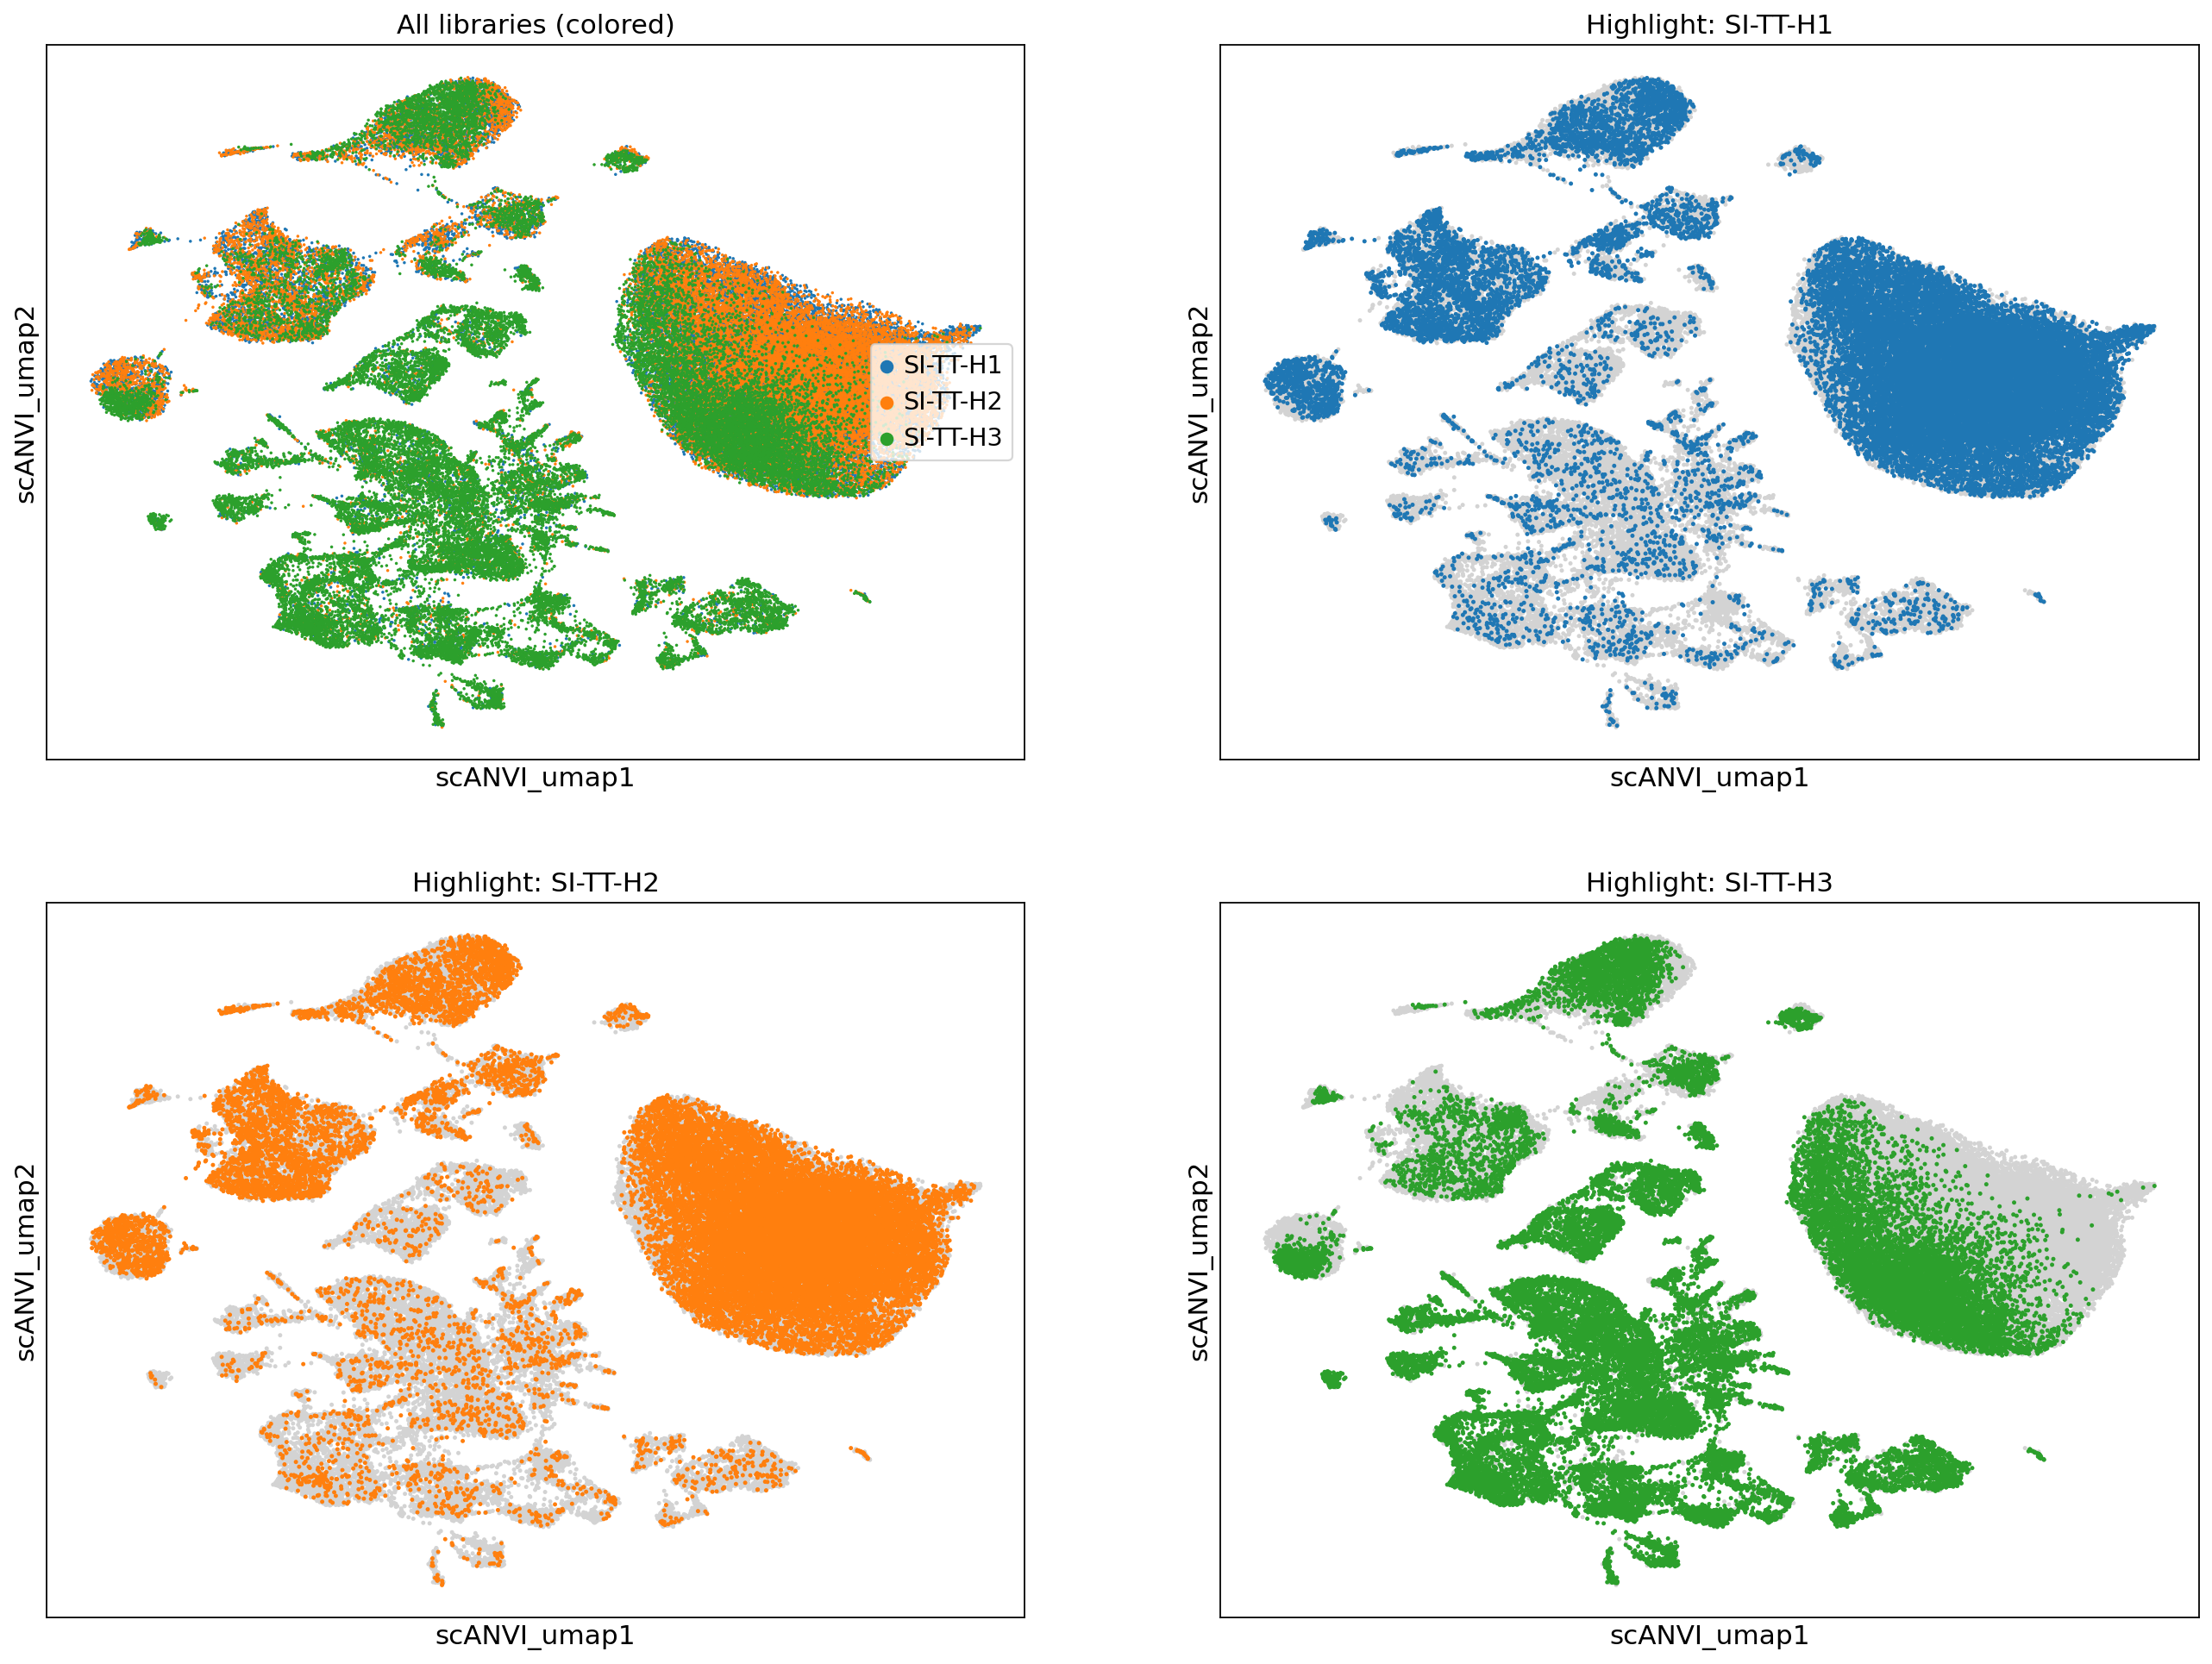

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

# 1) Combined plot: color by library
sc.pl.embedding(
    adata,
    color="library_name",
    ax=axes[0],
    legend_loc="right",
    title="All libraries (colored)",
    show=False,
    size=10, 
    basis='scANVI_umap' #ATTNETION, use this Base
)

# 2..4) Highlight each selected library (colored) and gray-out others
for i, lib in enumerate(adata.obs.library_name.unique().to_list(), start=1):

    sc.pl.embedding(
        adata,
        color="library_name",
        ax=axes[i],
        title=f"Highlight: {lib}",
        legend_loc=None,
        show=False,
        size=20,
        groups=[lib],
        basis='scANVI_umap'
    )

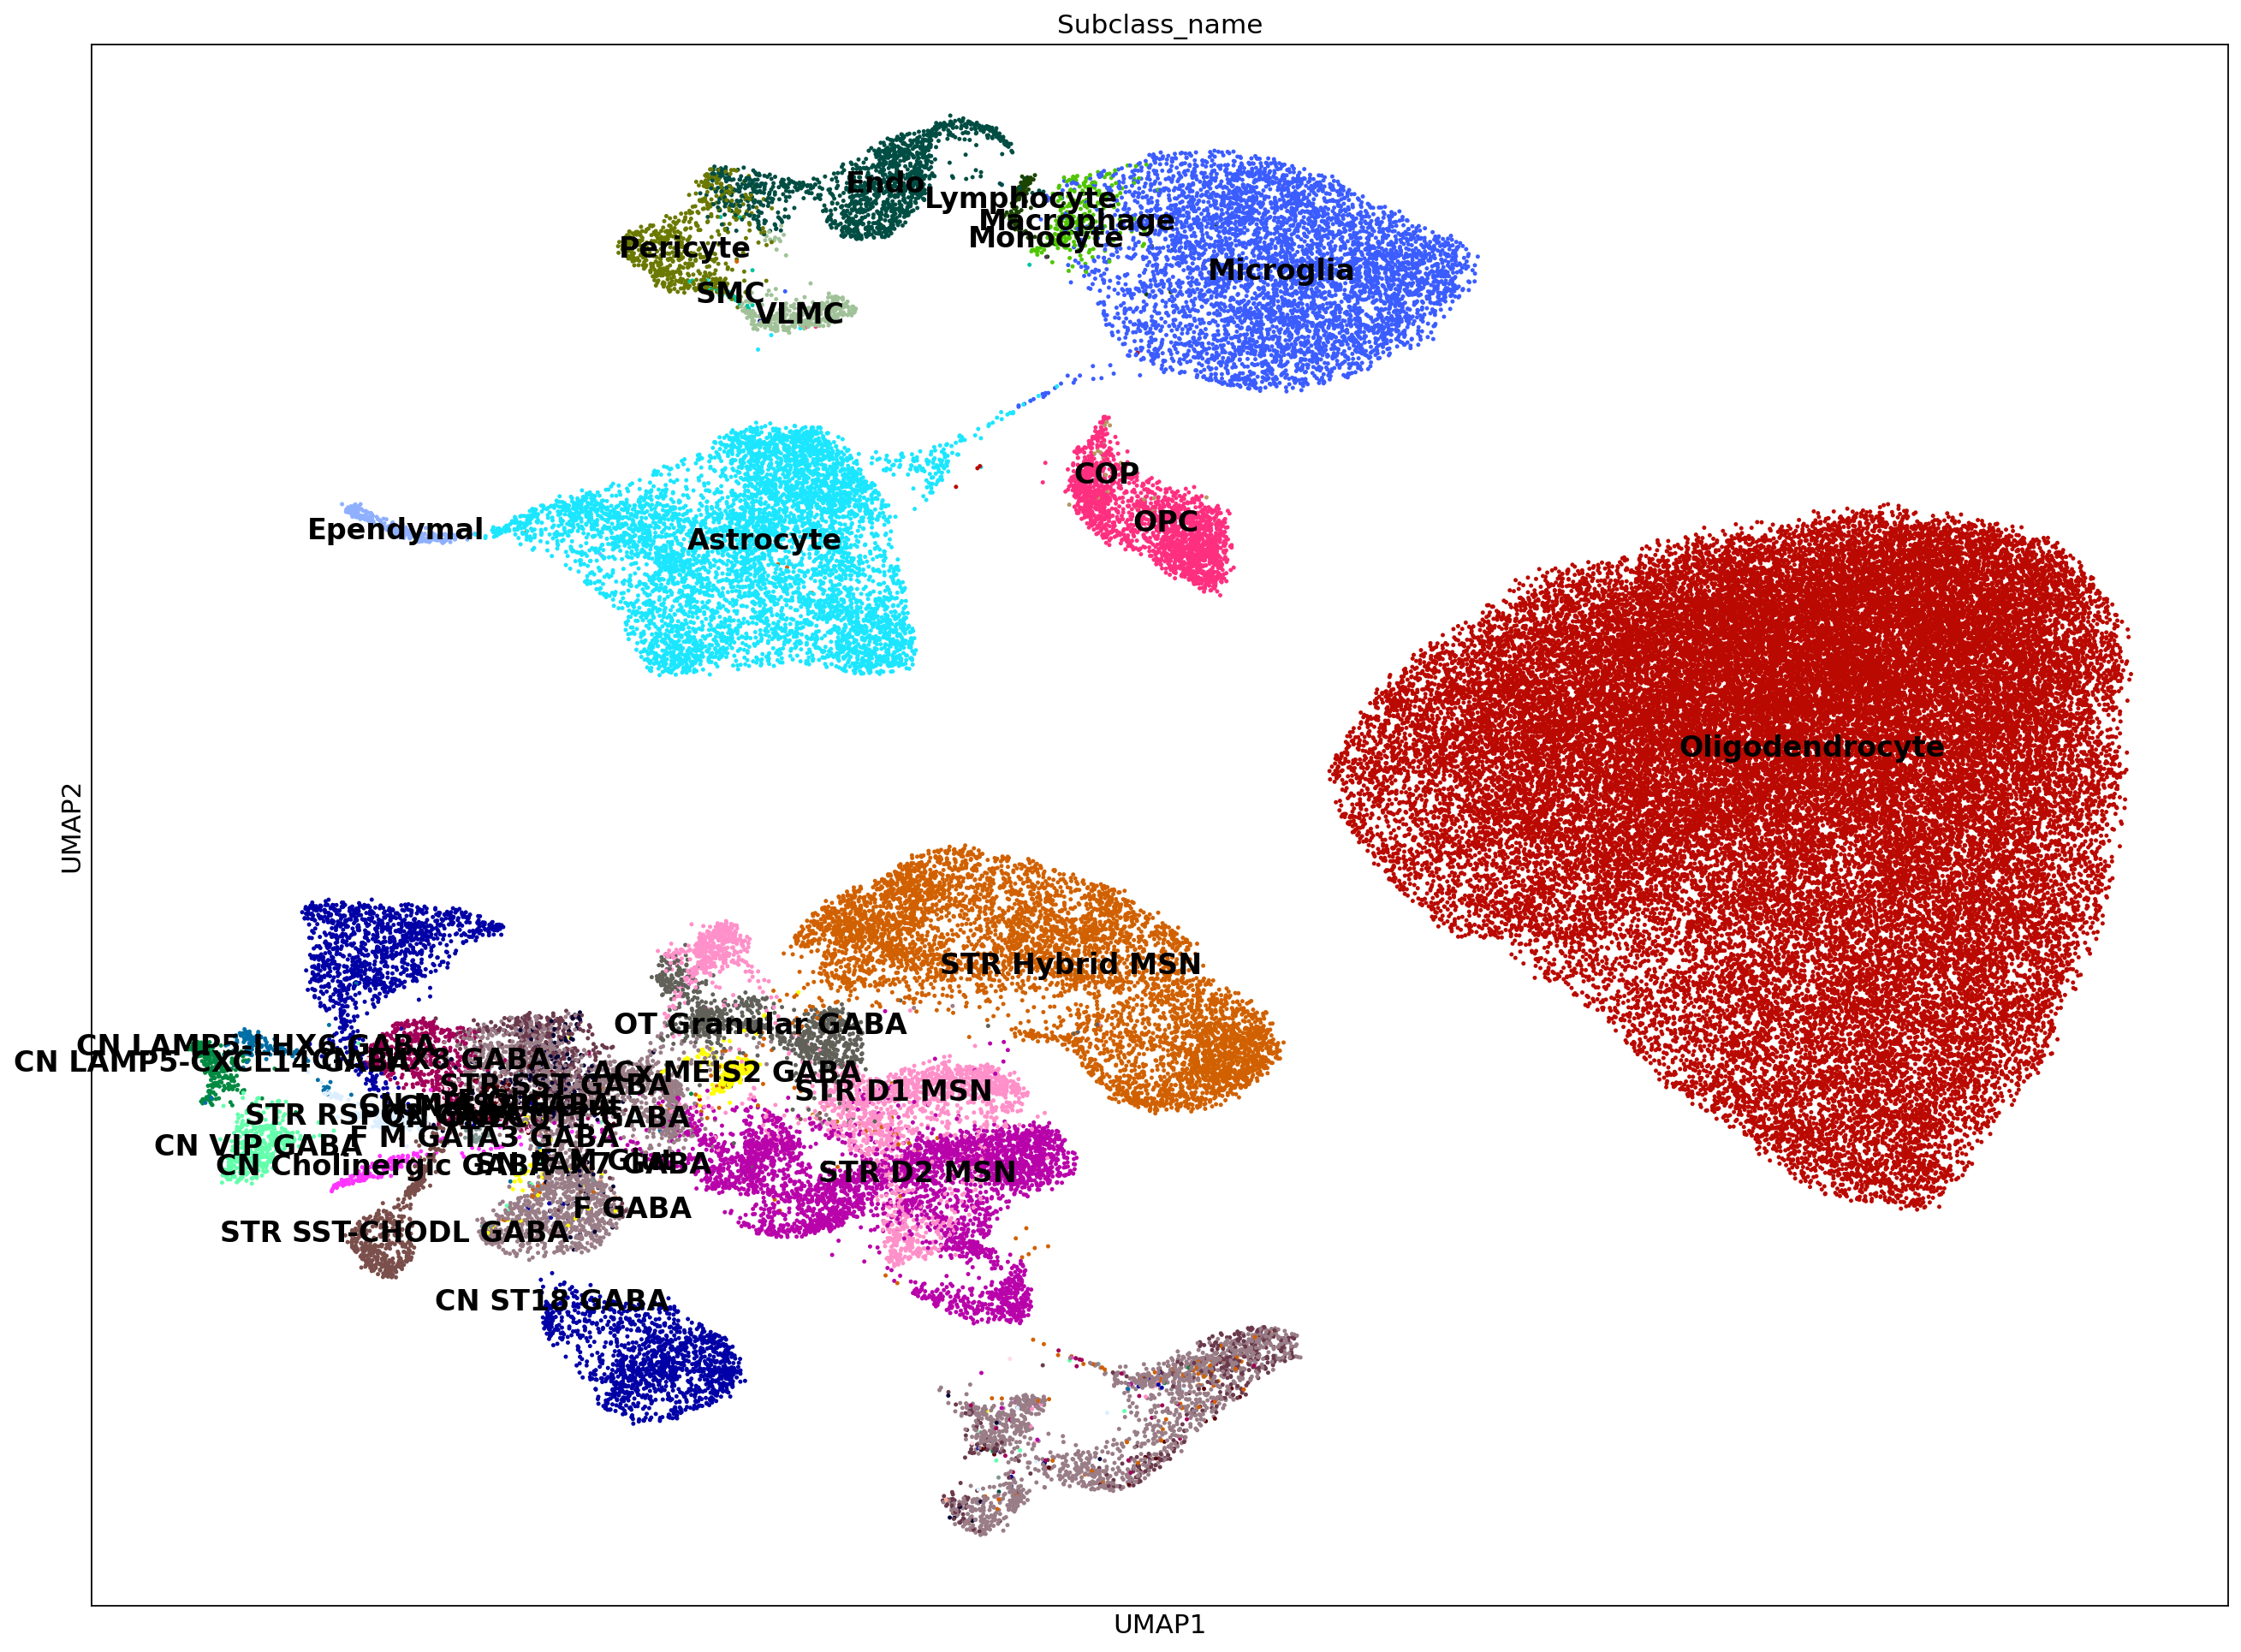

In [22]:
sc.settings.set_figure_params(figsize=(20, 15)) 
sc.pl.umap(
    adata,
    color=["Subclass_name"],
    legend_fontsize=15,
    size=20,
    ncols=1,
    legend_loc="on data"
)

# Save

In [ ]:
adata.write(f'/home/gdallagl/myworkdir/XDP/data/XDP/disease/{PATIENCE_ID}_adata.h5ad')
adata
del adata

# # 2. Save scVI model
# vae.save('scvi_model/', overwrite=True)

# # 3. Save scANVI model
# lvae.save('scanvi_model/', overwrite=True)

AnnData object with n_obs × n_vars = 84669 × 32780
    obs: 'x', 'y', 'pct_intronic', 'is_cell', 'dbscan_clusters', 'dbscan_score', 'has_spatial', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Subclass_aggregate_probability', 'Group_name', 'Group_bootstrapping_probability', 'Group_aggregate_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'my_hierarchy', 'my_hierarchy_all', 'library', 'library_name', 'leiden_scANVI'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns:

In [ ]:
adata = sc.red_h5ad(f'/home/gdallagl/myworkdir/XDP/data/XDP/disease/{PATIENCE_ID}_adata.h5ad')

# Collaspe 2 images

# Align images